In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.fasta import get_tokens, import_from_fasta, compute_weights
from adabmDCA.stats import get_freq_single_point, get_freq_two_points
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph
from adabmDCA.io import save_params, save_chains, load_params
from adabmDCA.dca import set_zerosum_gauge

import pickle

import sys
sys.path.append('..')
import utils

/home/scrotti/Aptamer2025py/.pixi/envs/default/lib/python3.12/site-packages/adabmDCA/training.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = get_device("")
dtype = get_dtype("float64")

Running on CPU


In [36]:
experiment_id = 'Dop8V030'
round_id = "R02N"
pseudocount = 0.99400516
dir = './saved/pseudocount/'
filepath = './saved/freq_pseudocount/' + experiment_id + 'freq_pseudocount' + \
    format(pseudocount, '.8f') + '.pkl'
with open(filepath, 'rb') as f:
    fi_, fij_, _ = pickle.load(f)
fi_target = fi_[0].to(dtype)
fij_target = fij_[0].to(dtype)
L, q = fi_target.shape

In [40]:
nchains = 10**3
sampler_alg = "gibbs"
    
sampler = torch.jit.script(get_sampler(sampler_alg))
print("Using sampler:", sampler_alg);

Using sampler: gibbs


In [41]:
params = init_parameters(fi=fi_target)
chains = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target, dtype=dtype)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
log_weights = torch.zeros(nchains, device=device, dtype=dtype)

In [ ]:
target = 0.99

chains, params, log_weights, history = train_graph(
    sampler=sampler,
    chains=chains,
    fi_target=fi_target,
    fij_target=fij_target,
    params=params,
    mask=mask,
    log_weights=log_weights,
    nsweeps=10,
    lr=0.05,
    max_epochs=200,
    target_pearson=target,
    )

 0.00%[                                       ] Pearson: 0.000/0.99 [00:00]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel(r"Pearson $C_{ij}$ correlation", fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()

In [ ]:
nchains = 10**5
sampler_alg = "gibbs"
    
sampler = torch.jit.script(get_sampler(sampler_alg))
print("Using sampler:", sampler_alg);

In [ ]:
params = init_parameters(fi=fi_target)
chains = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target, dtype=dtype)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
log_weights = torch.zeros(nchains, device=device, dtype=dtype)

In [ ]:
target = 0.99

chains, params, log_weights, history = train_graph(
    sampler=sampler,
    chains=chains,
    fi_target=fi_target,
    fij_target=fij_target,
    params=params,
    mask=mask,
    log_weights=log_weights,
    nsweeps=10,
    lr=0.05,
    max_epochs=200,
    target_pearson=target,
    )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel(r"Pearson $C_{ij}$ correlation", fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()

In [512]:
from adabmDCA.stats import get_freq_single_point, get_freq_two_points, get_correlation_two_points
from adabmDCA.utils import get_mask_save
from adabmDCA.statmech import _update_weights_AIS, compute_log_likelihood, compute_entropy, _compute_ess
from adabmDCA.checkpoint import Checkpoint
from adabmDCA.graph import activate_graph, compute_density, decimate_graph

pi = get_freq_single_point(data=chains)
pij = get_freq_two_points(data=chains)

(0.05, 0.07)

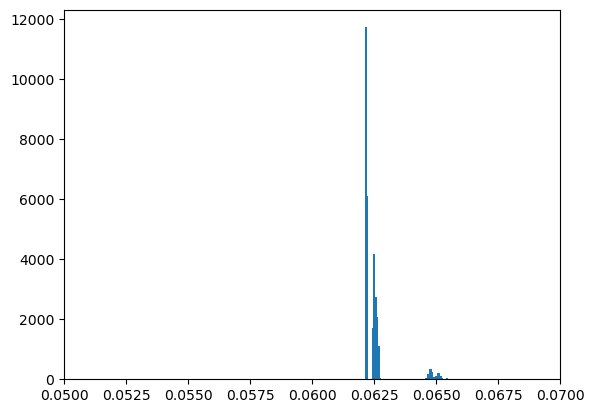

In [528]:
plt.hist((fij_target*mask).view(-1), bins=1000)
plt.xlim((0.05,0.07))

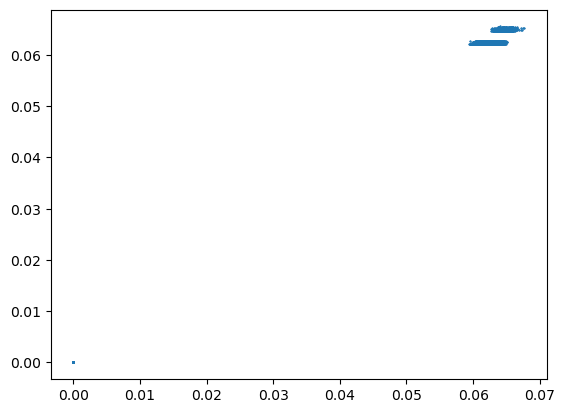

In [526]:
(pij - fij_target).mean()
pearson, slope = get_correlation_two_points(fij=fij_target, pij=pij, fi=fi_target, pi=pi)
Cij = pij - pi[:,:,None,None] * pi[None,None,:,:]
Cij_target = fij - fi_target[:,:,None,None] * fi_target[None,None,:,:]
plt.scatter(pij * mask, fij_target * mask, s=0.2)

In [ ]:
alpha = pseudocount
params_zerosum = utils.set_zerosum_gauge(params)

In [ ]:
filepath = './saved/freq_pseudocount/' + experiment_id + 'freq_pseudocount' + \
    format(0, '.8f') + '.pkl'
with open(filepath, 'rb') as f:
    fi_, fij_, _ = pickle.load(f)
fi = fi_[0]
fij = fij_[0]

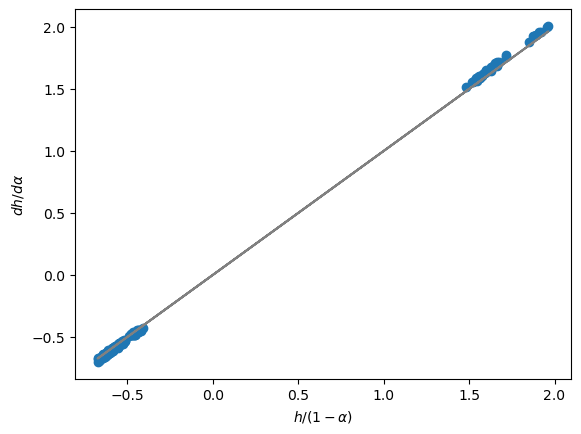

In [531]:
dhdalpha = q * fi - 1
h = params_zerosum['bias']
plt.scatter(h/(1-alpha), dhdalpha)
plt.xlabel(r"$h/(1-\alpha)$"); plt.ylabel(r"$dh/d\alpha$")
plt.plot((h/(1-alpha)).view(-1), (h/(1-alpha)).view(-1), color='gray')

In [ ]:
dJdalpha = 1/2 * q**2 * fij
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
dJdalpha = utils.zerosum_gauge_couplings(dJdalpha) 
dJdalpha = dJdalpha * mask
J = params_zerosum['coupling_matrix']
plt.scatter(J/(1-alpha), dJdalpha, s=2)
plt.xlabel(r"$J/(1-\alpha)$"); plt.ylabel(r"$dJ/d\alpha$")
plt.plot(dJdalpha.view(-1), dJdalpha.view(-1), color='black', linewidth=0.3)

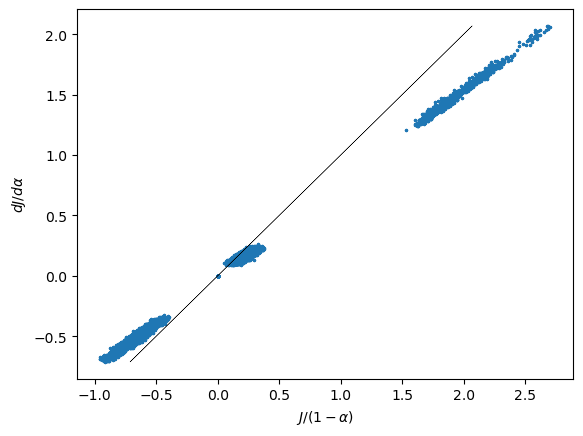

In [530]:
dJdalpha = 1/2 * q**2 * fij
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
dJdalpha = utils.zerosum_gauge_couplings(dJdalpha) 
dJdalpha = dJdalpha * mask
J = params_zerosum['coupling_matrix']
plt.scatter(J/(1-alpha), dJdalpha, s=2)
plt.xlabel(r"$J/(1-\alpha)$"); plt.ylabel(r"$dJ/d\alpha$")
plt.plot(dJdalpha.view(-1), dJdalpha.view(-1), color='black', linewidth=0.3)